In [61]:
import pickle


# a) Data preperation.
From Mehta's notebook 4.

## Creation of 1D

In [62]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

In [63]:
print(states)
print(states.shape)

[[ 1  1 -1 ... -1 -1 -1]
 [-1 -1  1 ... -1 -1 -1]
 [-1  1  1 ... -1 -1  1]
 ...
 [-1  1 -1 ... -1 -1  1]
 [ 1 -1 -1 ...  1 -1  1]
 [-1 -1  1 ... -1  1 -1]]
(10000, 40)


In [64]:
print(energies)
print(energies.shape)

[  4. -12.   4. ...   0.  -8.   8.]
(10000,)


In [65]:
# All possible spin combinations
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

In [66]:
print(len(Data))
print(Data[0].shape, Data[1].shape)

2
(10000, 1600) (10000,)


## Train

In [67]:
# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

In [27]:
print(X_train.shape)

(400, 1600)


/home/k/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


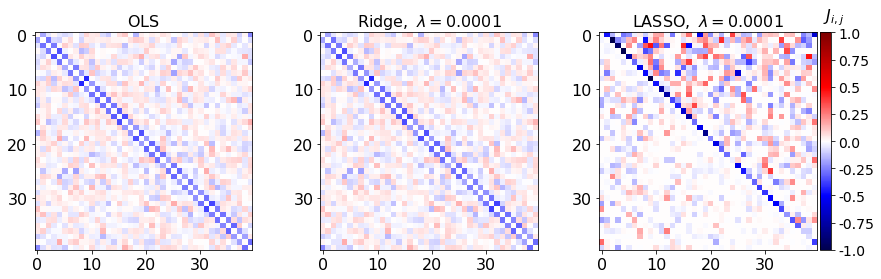

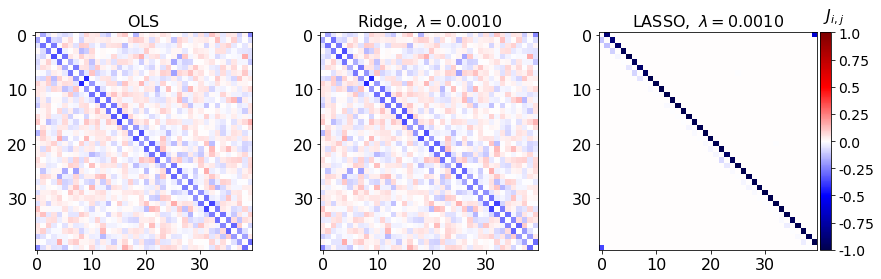

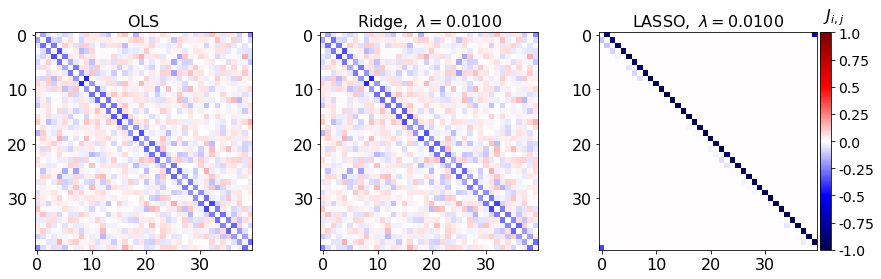

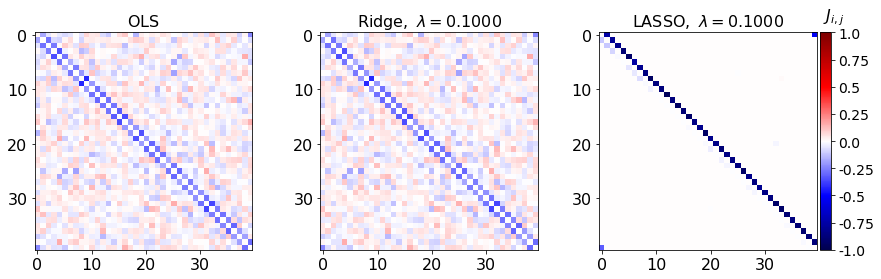

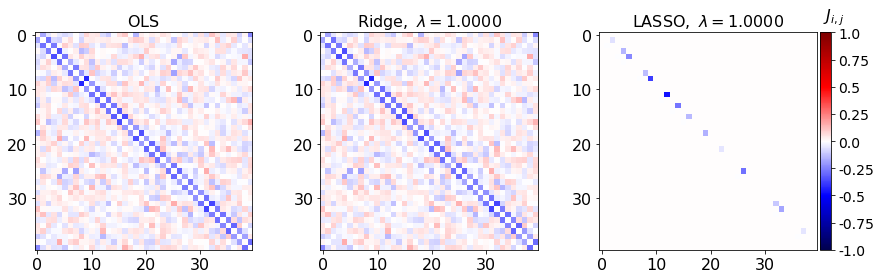

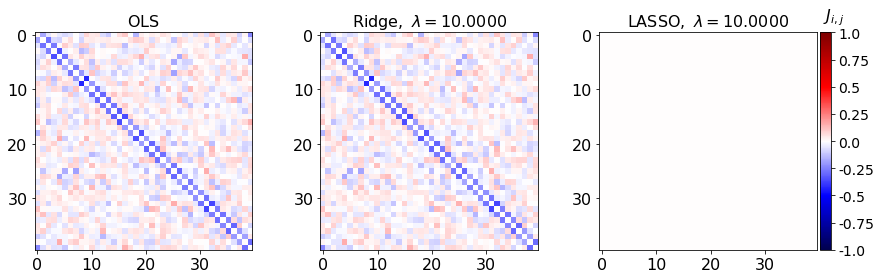

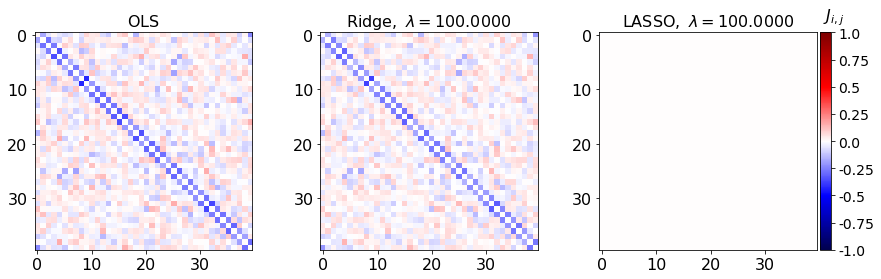

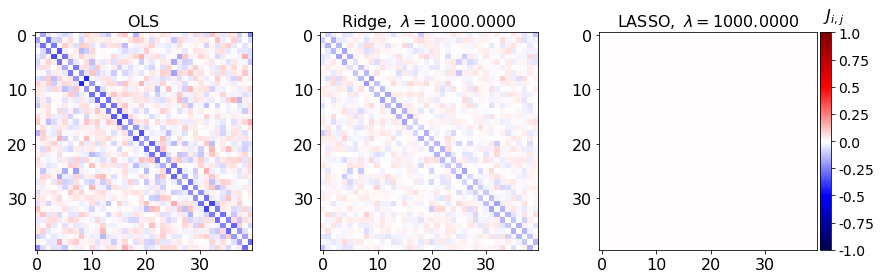

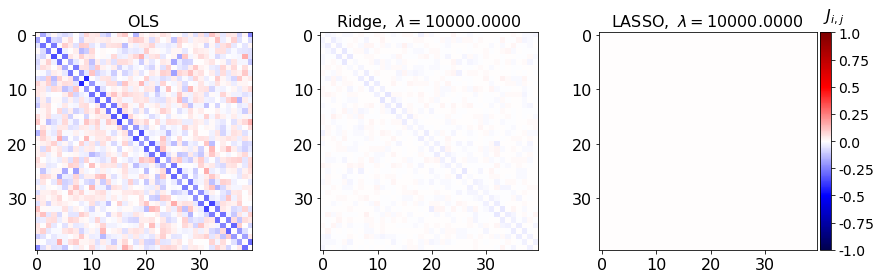

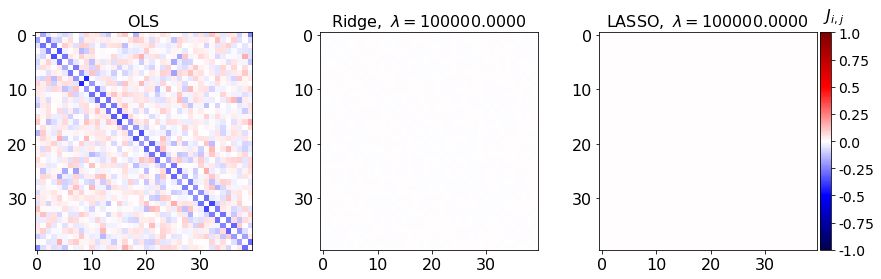

In [32]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set refularisations trength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply Ridge regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply Ridge regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

The OLS estimation seems to have largest values along the nearest diagnaol points to the diagonal, which represents the neigboiring spins. It is good that the OLS estimator gives largst coefficients along the these neigbouring diagonals, since the data was created by only neighbouring spins. <br>

The weights equal around -0.5 for Ridge and Lasso. This reflects the fact that each weight takes in two symmetric parts, e.g. $J_{j, j-1}$ and $J_{j, j+1}$ and the weights are distributed equally between these terms. Hence we have -1 on the digiagonal, or more precisely, on the nearest neigbour diagonals to the main diagonal. <mark> Imrpove! See Methta p.25. <br>
    
Lasso is the model that gives the best fit, since it, for a sufficiently large $\lambda$, is able to remove the insignifican parameters.

In [30]:
print(len(coefs_leastsq))
print(coefs_leastsq[0].shape)
print(coefs_leastsq[0])
print(np.mean(coefs_leastsq[0]))

10
(1600,)
[ 0.01719953 -0.16931932 -0.04915816 ...  0.04675437 -0.28581991
  0.        ]
-0.008035024305465955


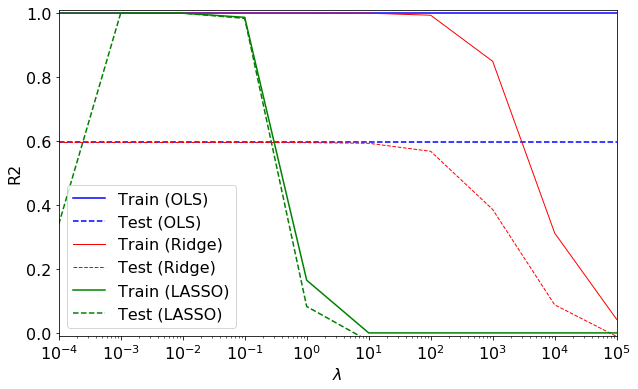

In [34]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('R2',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

We have overfitting for all models. The optimal $\lambda$ is around $10^{-2}$ for Lasso and $10$ for Ridge. The optima are found where the test performance peaks.

In [77]:
from collections import OrderedDict

def bootstrap(xData, yData,  R):
    n = xData.shape[0] 
    inds = np.arange(n); 
    
    betaList = [] 
    residualDictUnknownF = OrderedDict()
    for i in range(n):
        residualDictUnknownF[i] = []
    
    mseMatrixUnknownF = np.zeros(n)
    sdMatrixUnknownF = np.zeros(n)
    bias2MatrixUnknownF = np.zeros(n)
    totalMatrixUnknownF = np.zeros(n)

    # non-parametric bootstrap                                                                                                                                                     
    for i in range(R):
        idxTrain = np.random.randint(0,n,n)
        idxValid = np.setdiff1d(np.union1d(inds, idxTrain ), np.intersect1d(inds, idxTrain))
        
        x_train = xData[idxTrain]
        y_train = yData[idxTrain]
        x_valid = xData[idxValid]
        y_valid = yData[idxValid]
        
        ridge.set_params(alpha=lmbda) # set regularisation parameter
        ridge.fit(x_train, y_train) # fit model
        yPredict = ridge.predict(x_valid)
        
        for i in range(len(idxValid)):
            residualDictUnknownF[i].append(y_valid[i] -yPredict[i])
        
    for i in range(len(residualDictUnknownF)):
        mseMatrixUnknownF[i] = np.mean([(residualDictUnknownF[i][j])**2 for j in range(len(residualDictUnknownF[i]))])#np.mean( (residualDictUnknownF[key])**2 )
        sdMatrixUnknownF[i] = np.var( residualDictUnknownF[i] )
        bias2MatrixUnknownF[i] = ( np.mean(residualDictUnknownF[i]) )**2
        totalMatrixUnknownF[i] = sdMatrixUnknownF[i] + \
bias2MatrixUnknownF[i]
                                        
    mseUnknownF = np.nanmean(mseMatrixUnknownF)
    sdUnknownF = np.nanmean(sdMatrixUnknownF)
    bias2UnknownF = np.nanmean(bias2MatrixUnknownF)
    totalUnknownF = np.nanmean(totalMatrixUnknownF)
    
    return mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF

R = 200
xData = X_train
yData = Y_train
mses, sds, biases, totals = [], [], [], []
for lmbda in lmbdas:
    mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF = bootstrap(xData, yData,  R)   
    mses.append(mseUnknownF)
    sds.append(sdUnknownF)
    biases.append(bias2UnknownF)
    totals.append(totalUnknownF)
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)


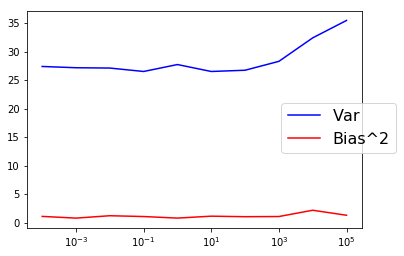

In [84]:
#print(mseUnknownF, sdUnknownF, bias2UnknownF, totalUnknownF)
fig, ax = plt.subplots()
ax.semilogx(lmbdas, sds, 'b',label='Var')
ax.semilogx(lmbdas, biases, 'r',label='Bias^2')
fig.legend(loc='right',fontsize=16)

In [72]:
from collections import OrderedDict

def errorBootstrap(data,  bootstraps=2): 
        numberOfObservation = np.shape(data)[0]
        
        #self.bootstraps = bootstraps
        betaList = [] 
        residualDictUnknownF = OrderedDict()

        for i in range(numberOfObservations):
            residualDictUnknownF[i] = []

        zPredictMeanMatrix = np.zeros(self.numberOfObservations)
        
		# Bias-variance decomposition when f is unknows
        mseMatrixUnknownF = np.zeros(self.numberOfObservations)
        sdMatrixUnknownF = np.zeros(self.numberOfObservations)
        bias2MatrixUnknownF = np.zeros(numberOfObservations)
        totalMatrixUnknownF = np.zeros(numberOfObservations)

        for iteration in range(bootstraps):
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)

            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]
            
            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D        
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
         
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            self.predict()           # --> zPredict
            
            self.mseBootstrap[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Bootstrap[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                residualDictUnknownF[coordinate].append(self.z[index] - self.zPredict[index]) # unknown f
                
            
            self.error2[iteration] = 0            
            for i in range(len(self.x)):
                self.error2[iteration] += (self.z[i] - self.zPredict[i])**2
            
        for key, index in zip(residualDictUnknownF, range(len(residualDictUnknownF))):
			# Bias variance unknown f
            mseMatrixUnknownF[key[0], key[1]] = np.mean([(residualDictUnknownF[key][i])**2 for i in range(len(residualDictUnknownF[key]))])#np.mean( (residualDictUnknownF[key])**2 )
            sdMatrixUnknownF[key[0], key[1]] = np.var( residualDictUnknownF[key] )
            bias2MatrixUnknownF[key[0], key[1]] = ( np.mean(residualDictUnknownF[key]) )**2
            totalMatrixUnknownF[key[0], key[1]] = sdMatrixUnknownF[key[0], key[1]] + \
bias2MatrixUnknownF[key[0], key[1]]
         
        
		# Bias-variance average all positions
        self.mseUnknownF = np.nanmean(np.reshape(mseMatrixUnknownF, -1, 1))
        self.sdUnknownF = np.nanmean(np.reshape(sdMatrixUnknownF, -1, 1))
        self.bias2UnknownF = np.nanmean(np.reshape(bias2MatrixUnknownF, -1, 1))
        self.totalUnknownF = np.nanmean(np.reshape(totalMatrixUnknownF, -1, 1))
        
        self.error2 = np.sum(self.error2)
        self.mseBootStrapMA = self.movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = self.movingAvg(self.R2Bootstrap)
        self.betaRunning = np.zeros((len(betaList[0]), len(betaList)))
        self.varianceBetaBootstrap = np.zeros((len(betaList[0]), len(betaList)))
        '''
        for i in range(len(betaList)):
            self.betaRunning[i, :] = self.movingAvg(betaList[i])
            self.varianceBetaBootstrap[i, :] = self.runningVariance(betaList[i])
        #self.betaRunning = self.movingAvg(betaList)
        
        self.varMSE = self.runningVarianceVector(self.mseBootstrap)
        '''
self.varianceBetaBootstrap = self.runningVariance(betaList)

NameError: name 'self' is not defined

## Importing from data link. 2D.

In [20]:
import pickle
def read_t(t,root="./"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

root = '/home/k/doc/subj/att/fys-stk4155/m2/IsingData/'

from collections import OrderedDict
data = OrderedDict()

temperaturs = [0.75, 2.3, 4.0]
for t in temperaturs:
    data[t] = read_t(t=0.75, root=root)

In [22]:
print(data)
print(data[0.75].shape)

OrderedDict([(0.75, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])), (2.3, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])), (4.0, array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]]))])
(10000, 1600)


In [25]:
import numpy as np
import pickle
from matplotlib import pyplot as plt

def read_t(t=0.25,root="./"):
    if t > 0.:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    else:
        data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=All.pkl','rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

stack = []
for i,t in enumerate(np.arange(0.25,4.01,0.25)):
    y = np.ones(10000,dtype=int)
    if t > 2.25:
        y*=0
    stack.append(y)

pickle.dump(np.vstack(y),open('labels_all.pkl','wb'))

#X = read_t(-1)
''' for i in range(16):
    print(np.arange(0.25,4.01,0.25)[i])
    x = X[i*10000].reshape(40,40)
    plt.imshow(x)
    plt.show() '''


''' stack = []
for t in np.arange(0.25,4.01,0.25):
    stack.append(read_t(t))

X = np.vstack(stack)
pickle.dump(np.packbits(X), open('Ising2DFM_reSample_L40_T=All.pkl','wb')) '''

" stack = []\nfor t in np.arange(0.25,4.01,0.25):\n    stack.append(read_t(t))\n\nX = np.vstack(stack)\npickle.dump(np.packbits(X), open('Ising2DFM_reSample_L40_T=All.pkl','wb')) "

In [26]:
y

array([0, 0, 0, ..., 0, 0, 0])